# `RANFIS` tutorial

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from ANFISpy import RANFIS

Generating synthetic data.

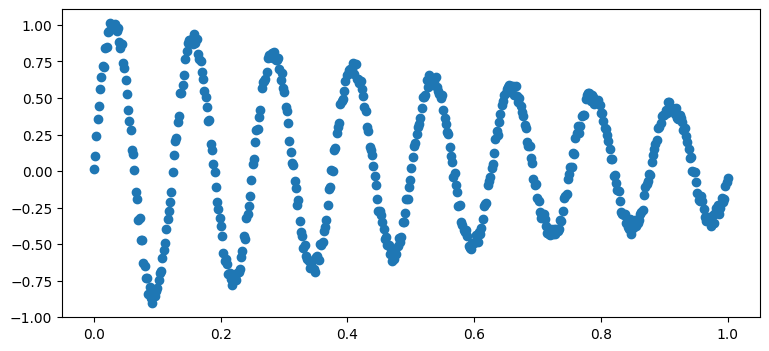

In [2]:
time = np.linspace(0, 1, 500)
data = np.sin(time * 50) * np.exp(- time) + 0.1 * np.random.random(500)

plt.figure(figsize=(9, 4))
plt.scatter(time, data)
plt.show()

Splitting the data into sequences.

In [3]:
x, y, t = [], [], []
seq_len = 10

for i in range(len(data) - seq_len): 
    x.append(data[i : i + seq_len])  
    y.append(data[i + seq_len])      
    t.append(time[i + seq_len])

x = torch.FloatTensor(np.array(x)).unsqueeze(-1)  
y = torch.FloatTensor(np.array(y)).unsqueeze(-1)  
t = np.array(t)

train_size = int(0.7 * len(x))
val_size = int(0.15 * len(x))

x_train, y_train, t_train = x[:train_size], y[:train_size], t[:train_size]
x_val, y_val, t_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size], t[train_size:train_size + val_size]
x_test, y_test, t_test = x[train_size + val_size:], y[train_size + val_size:], t[train_size + val_size:]

Instatiating RANFIS. Note that this is a RNN based ANFIS, so it is best suited for time series.

In [4]:
n_vars = 1
mf_names = [['L', 'M', 'H']]

variables = {
    'inputs': {
        'n_sets': [5],
        'uod': n_vars * [(0, 1)],
        'var_names': ['t'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'out',
        'n_classes': 1,
    },
}

ranfis = RANFIS(variables, 'bell', output_activation=nn.Identity())

Training the model.

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ranfis.parameters(), lr=0.01)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs, _ = ranfis(x_train)
    loss_train = criterion(outputs[:, -1, :] , y_train)
    loss_train.backward()
    optimizer.step()
    
    ranfis.eval()
    with torch.no_grad():
        outputs, _ = ranfis(x_val)
        loss_val = criterion(outputs[:, -1, :] , y_val)
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch} | Train Loss: {loss_train.item():.5f} | Validation Loss: {loss_val.item():.5f}')

Epoch 0 | Train Loss: 1.14438 | Validation Loss: 1.30277
Epoch 50 | Train Loss: 0.00933 | Validation Loss: 0.00657
Epoch 100 | Train Loss: 0.00487 | Validation Loss: 0.00270
Epoch 150 | Train Loss: 0.00335 | Validation Loss: 0.00220
Epoch 200 | Train Loss: 0.00271 | Validation Loss: 0.00195
Epoch 250 | Train Loss: 0.00238 | Validation Loss: 0.00174
Epoch 300 | Train Loss: 0.00217 | Validation Loss: 0.00162
Epoch 350 | Train Loss: 0.00203 | Validation Loss: 0.00155
Epoch 400 | Train Loss: 0.00195 | Validation Loss: 0.00151
Epoch 450 | Train Loss: 0.00191 | Validation Loss: 0.00151
Epoch 500 | Train Loss: 0.00188 | Validation Loss: 0.00151
Epoch 550 | Train Loss: 0.00186 | Validation Loss: 0.00151
Epoch 600 | Train Loss: 0.00185 | Validation Loss: 0.00151
Epoch 650 | Train Loss: 0.00184 | Validation Loss: 0.00151
Epoch 700 | Train Loss: 0.00183 | Validation Loss: 0.00151
Epoch 750 | Train Loss: 0.00182 | Validation Loss: 0.00151
Epoch 800 | Train Loss: 0.00181 | Validation Loss: 0.00151


Plotting the model outputs.

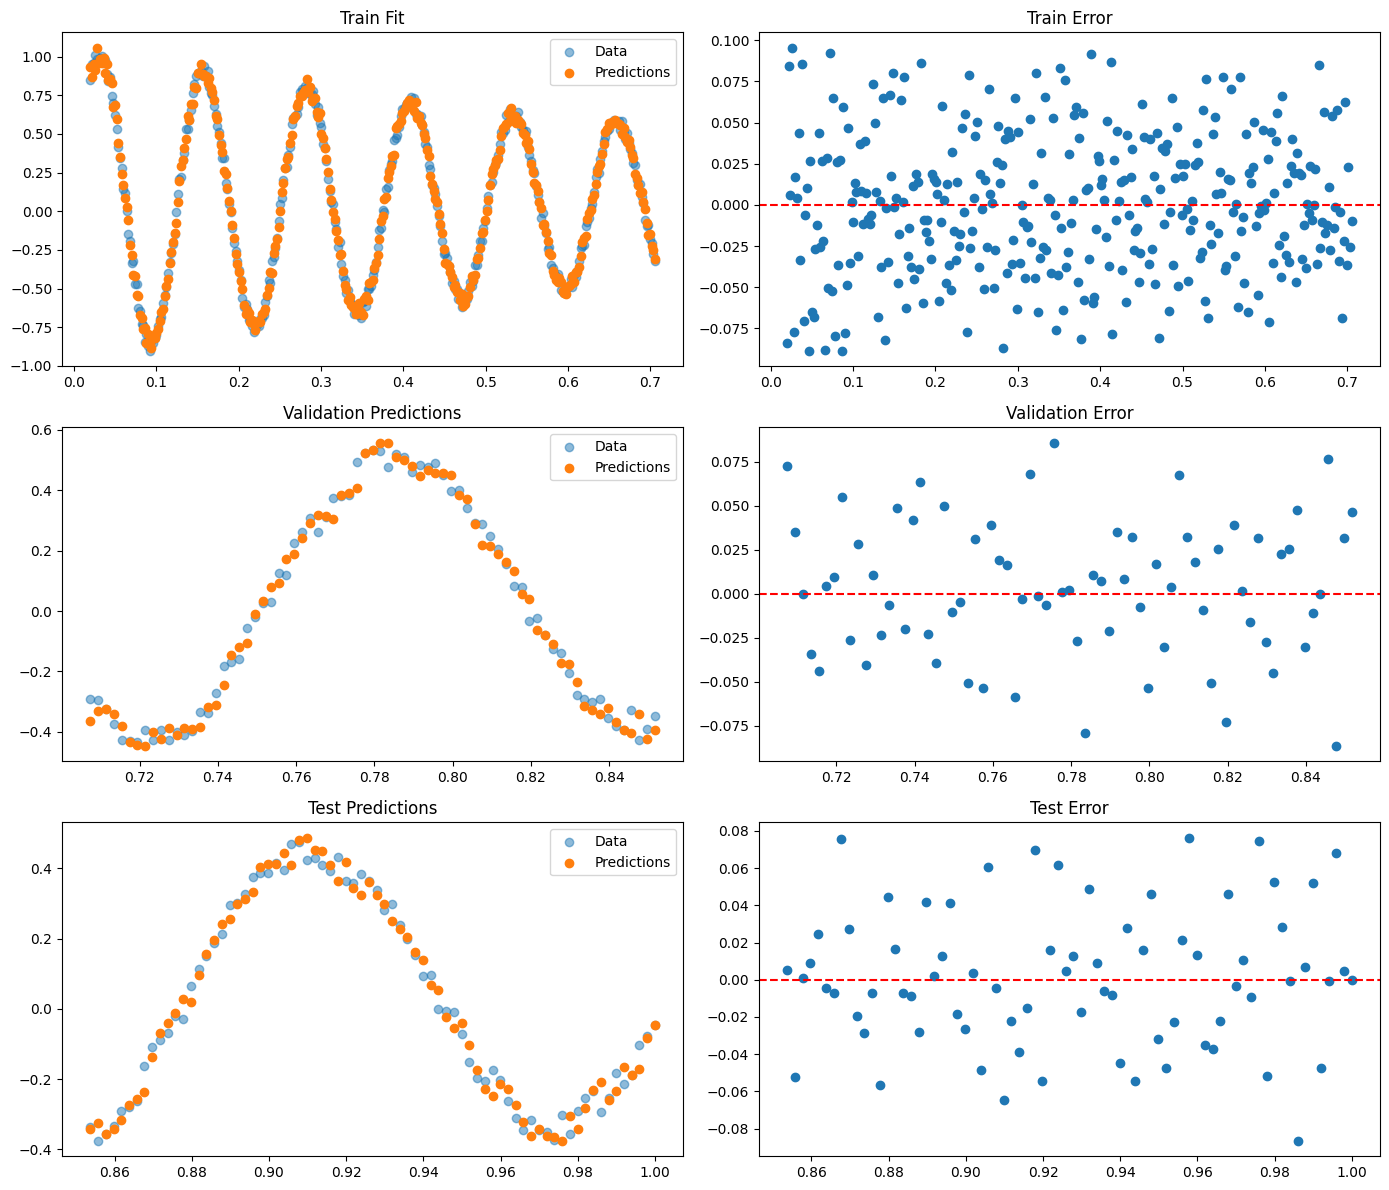

In [6]:
ranfis.eval()

with torch.no_grad():
    train_predictions = ranfis(x_train)[0][:, -1, :].numpy().flatten()
    val_predictions = ranfis(x_val)[0][:, -1, :].numpy().flatten()
    test_predictions = ranfis(x_test)[0][:, -1, :].numpy().flatten()

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].scatter(t_train, y_train.numpy(), label='Data', alpha=0.5)
axes[0, 0].scatter(t_train, train_predictions, label='Predictions')
axes[0, 0].legend()
axes[0, 0].set_title('Train Fit')

axes[0, 1].scatter(t_train, y_train.numpy().flatten() - train_predictions)
axes[0, 1].axhline(0, c='red', linestyle='--')
axes[0, 1].set_title('Train Error')

axes[1, 0].scatter(t_val, y_val.numpy(), label='Data', alpha=0.5)
axes[1, 0].scatter(t_val, val_predictions, label='Predictions')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Predictions')

axes[1, 1].scatter(t_val, y_val.numpy().flatten() - val_predictions)
axes[1, 1].axhline(0, c='red', linestyle='--')
axes[1, 1].set_title('Validation Error')

axes[2, 0].scatter(t_test, y_test.numpy(), label='Data', alpha=0.5)
axes[2, 0].scatter(t_test, test_predictions, label='Predictions')
axes[2, 0].legend()
axes[2, 0].set_title('Test Predictions')

axes[2, 1].scatter(t_test, y_test.numpy().flatten() - test_predictions)
axes[2, 1].axhline(0, c='red', linestyle='--')
axes[2, 1].set_title('Test Error')

plt.tight_layout()
plt.show()